# 1D Burgers Equation

* Jax-ify
* Don't Reinvent the Wheel

In [86]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Burgers 1D


Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2}
\end{aligned}
$$ (eq:1dburgers)


Here, we are advised to a backwards difference for the advection term, a second order central difference for the diffusion term and a first order time stepper for the time derivative.

::: {note} Initial Conditions

This probably has the most complicated initialization function I've seen in a while. It contains two functions:

$$
\begin{aligned}
u(x,t,\nu) &= - \frac{2\nu}{\phi}\frac{\partial \phi}{\partial x} + 4 \\
\phi(x,t,\nu) &= \exp\left(\frac{-(x-4t)^2}{4\nu(t+1)}\right) + \exp\left(\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{aligned}
$$

Notice that the $\boldsymbol{u}(x,t,\nu)$ has another function $\phi$ as well as its partial derivative wrt to $x$, $\partial_x\phi$.

:::

::: {note} Boundary Conditions

For the boundary conditions, we will use periodic boundary conditions.

$$
\mathcal{BC}[u](x, t) = -1, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)

:::

In [87]:
from jaxsw._src.models.tutorial import burgers1d as burgers
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.domain.time import TimeDomain

# initialize spatial domain
nx = 100
xmin = 0.0
xmax = 2.0 * jnp.pi

domain = Domain.init_domain_1d(xmin, xmax, nx)


# initialize parameters
nu = 0.07

params = burgers.Params(bc_fn=burgers.bc_fn, nu=nu, domain=domain)

# initialize field
u_init = burgers.init_u_batch(domain.coords.squeeze(), 0, nu)

# initialize time domain
t0, t1 = 0.0, 0.5
c = 1.0
sigma = 0.2
dt = sigma * domain.dx[0] * nu

t_domain = TimeDomain(tmin=t0, tmax=t1, dt=dt)
num_save = 50
ts_out = jnp.linspace(t0, t1, num_save)
saveat = dfx.SaveAt(ts=ts_out)


# initialize dynamical model
dyn_model = burgers.Burgers1D(t_domain=t_domain)

# calculate rhs
rhs = dyn_model.equation_of_motion(t=0, u=u_init, params=params)

# do integration
sol = dyn_model.integrate(u0=u_init, dt0=dt, saveat=saveat, params=params)

## Analysis

In [88]:
u_analytical = jax.vmap(burgers.init_u_batch, in_axes=(None, 0, None))(domain.coords_axis[0], ts_out, nu)
u_analytical.shape, sol.ys.shape, sol.ts.shape

((50, 100), (50, 100), (50,))

In [89]:
da_sol = xr.DataArray(
    data=np.asarray(sol.ys),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords_axis[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)

da_analytical = xr.DataArray(
    data=np.asarray(u_analytical),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords_axis[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)

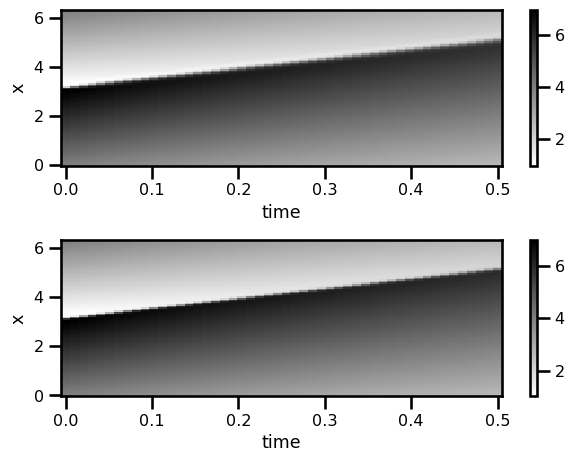

In [90]:
fig, ax = plt.subplots(nrows=2)

da_sol.T.plot.pcolormesh(ax=ax[0], cmap="gray_r")
da_analytical.T.plot.pcolormesh(ax=ax[1], cmap="gray_r")

plt.tight_layout()
plt.show()

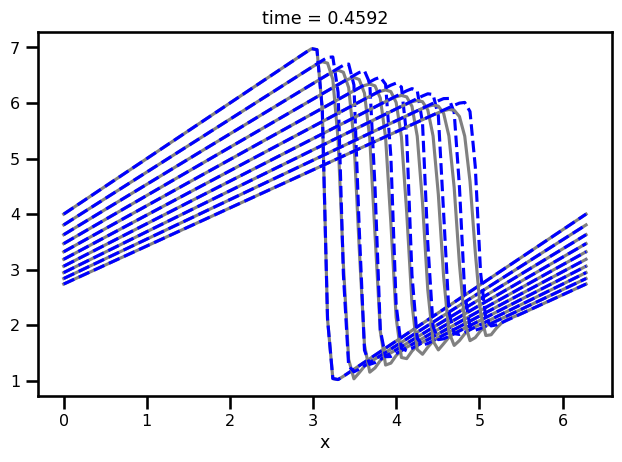

In [91]:
fig, ax = plt.subplots()

for i in range(0, len(da_sol.time), 5):
    da_sol.isel(time=i).plot.line(ax=ax, color="gray")
    da_analytical.isel(time=i).plot.line(ax=ax, color="blue", linestyle="--")

plt.tight_layout()
plt.show()

## Burgers 2D


We will solve the 2D Burgers Scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 
\nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{aligned}
$$ (eq:2d_burgers)

where $\nu$ is the diffusivity. Here, we are advised to:
* Diffusion Term - 2nd order accurate central difference scheme
* Advection Term - 1st order accuracy backwards difference scheme
* Time Step - 1st order temporal scheme (Euler).
* Initialization - same hat
* Boundaries - 1's everywhere

::: {note} Initial Conditions

We're doing the same hat initialization as before.

$$
\begin{aligned}
\mathcal{IC}[u],\mathcal{IC}[v] &=
\begin{cases}
2 && \text{for }x,y \in (0.5, 1)\times(0.5,1) \\
1 && \text{everywhere else}
\end{cases}
\end{aligned}
$$


:::



::: {note} Boundary Conditions
<!-- :class: dropdown -->

We are using the same boundary conditions as before, 1's everywhere. 

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

Note, we use the same BCs for both $u$ and $v$.

:::

In [33]:
from jaxsw._src.models.tutorial import burgers2d as burgers
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.domain.time import TimeDomain

In [73]:
nx, ny = 50, 50
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [74]:
# x,y domains
x_domain = Domain.init_domain_1d(xmin, xmax, nx)
y_domain = Domain.init_domain_1d(ymin, ymax, ny)

# combine domains
xy_domain = x_domain * y_domain

print(f"Nx: {xy_domain.Nx}")
print(f"Lx: {xy_domain.Lx}")
print(f"dx: {xy_domain.dx}")
print(f"nDims: {xy_domain.ndim}")
print(f"Cell Volume: {xy_domain.cell_volume}")

Nx: (50, 50)
Lx: (2.0, 2.0)
dx: (0.04081632653061224, 0.04081632653061224)
nDims: 2
Cell Volume: 0.0016659725114535606


In [75]:
# initialize parameters
nu = 0.01

params = burgers.Params(bc_fn=burgers.bc_fn, nu=nu, domain=xy_domain)

# initialize field
u_init = burgers.init_u(xy_domain)
v_init = burgers.init_u(xy_domain)

# initialize states
state = burgers.State(u=u_init, v=v_init)

In [80]:
# initialize time domain
t0, t1 = 0.0, 0.5
c = 1.0
sigma = .0009
dt = sigma * np.prod(domain.dx) / nu

t_domain = TimeDomain(tmin=t0, tmax=t1, dt=dt)
num_save = 50
ts_out = jnp.linspace(t0, t1, num_save)
saveat = dfx.SaveAt(ts=ts_out)

# initialize dynamical model
dyn_model = burgers.Burgers2D(t_domain=t_domain)

# calculate rhs (check)
rhs = dyn_model.equation_of_motion(t=0, state=state, params=params)

# do integration
solver = dfx.Dopri5()
sol = dyn_model.integrate(u0=state, dt0=dt, saveat=saveat, params=params, solver=solver)

### Analysis

In [81]:
da_sol = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), np.asarray(sol.ys.u)),
        "v": (("time", "x", "y"), np.asarray(sol.ys.v)),
    },
    coords={
        "x": (["x"], np.asarray(xy_domain.coords_axis[0])),
        "y": (["y"], np.asarray(xy_domain.coords_axis[1])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "nonlinear_convection", "sigma": sigma},
)
da_sol

<xarray.Dataset>
Dimensions:  (time: 50, x: 50, y: 50)
Coordinates:
  * x        (x) float64 0.0 0.04082 0.08163 0.1224 ... 1.878 1.918 1.959 2.0
  * y        (y) float64 0.0 0.04082 0.08163 0.1224 ... 1.878 1.918 1.959 2.0
  * time     (time) float64 0.0 0.0102 0.02041 0.03061 ... 0.4796 0.4898 0.5
Data variables:
    u        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.001 1.001 1.0
    v        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.001 1.001 1.0
Attributes:
    pde:      nonlinear_convection
    sigma:    0.0009

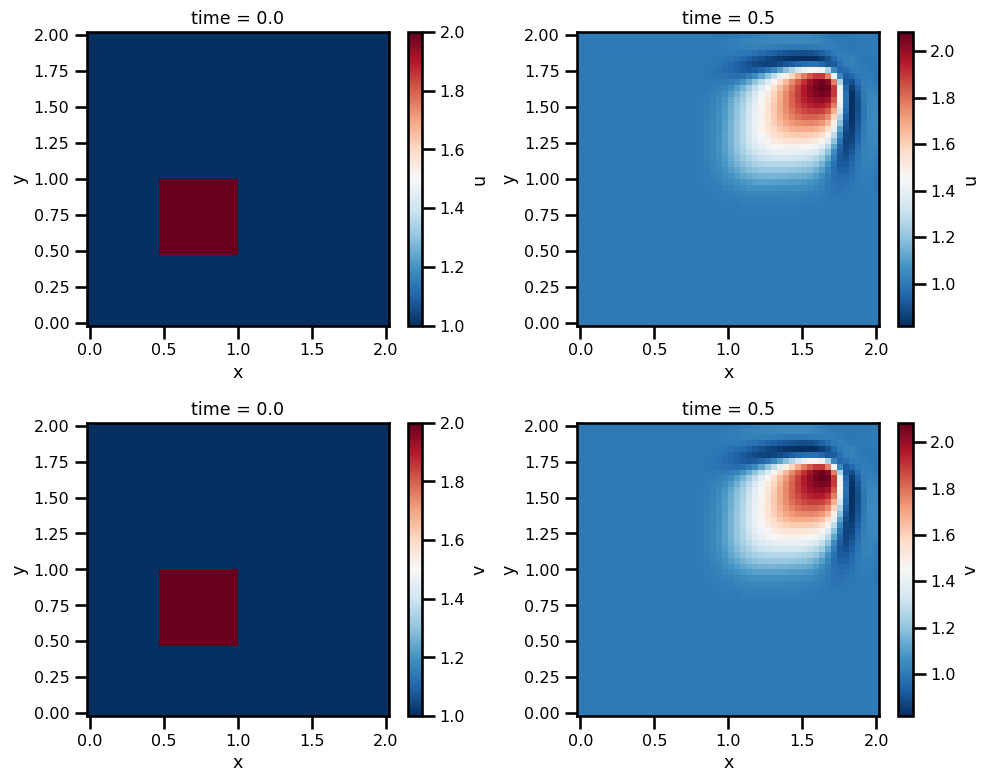

In [82]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

# U
da_sol.u.isel(time=0).T.plot.pcolormesh(ax=ax[0, 0], cmap="RdBu_r")
da_sol.u.isel(time=-1).T.plot.pcolormesh(ax=ax[0, 1], cmap="RdBu_r")

# V
da_sol.v.isel(time=0).T.plot.pcolormesh(ax=ax[1, 0], cmap="RdBu_r")
da_sol.v.isel(time=-1).T.plot.pcolormesh(ax=ax[1, 1], cmap="RdBu_r")

plt.tight_layout()
plt.show()

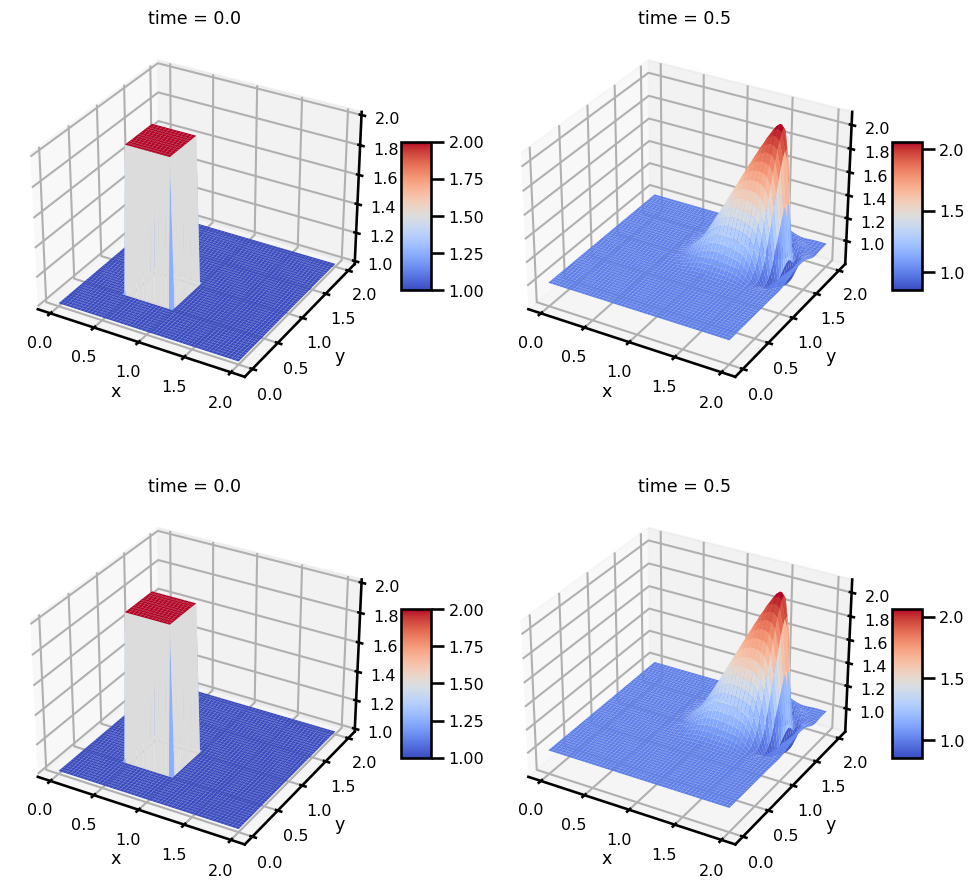

In [83]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, subplot_kw={"projection": "3d"}, figsize=(10, 10)
)

vmin = da_sol.min()
vmax = da_sol.max()

cbar_kwargs = dict(shrink=0.3, aspect=5)

# U
vmin = None  # da_sol.u.min()
vmax = None  # da_sol.u.max()

pts = da_sol.u.isel(time=0).T.plot.surface(
    ax=ax[0, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.u.isel(time=-1).T.plot.surface(
    ax=ax[0, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)

# V
vmin = None  # da_sol.v.min()
vmax = None  # da_sol.v.max()
pts = da_sol.v.isel(time=0).T.plot.surface(
    ax=ax[1, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.v.isel(time=-1).T.plot.surface(
    ax=ax[1, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
plt.tight_layout()
plt.show()